In [1]:
# Import packages and functions
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from shapely.geometry import Polygon

from pystac_client import Client
import planetary_computer

import rasterio
from rasterio.plot import show
import contextily as ctx

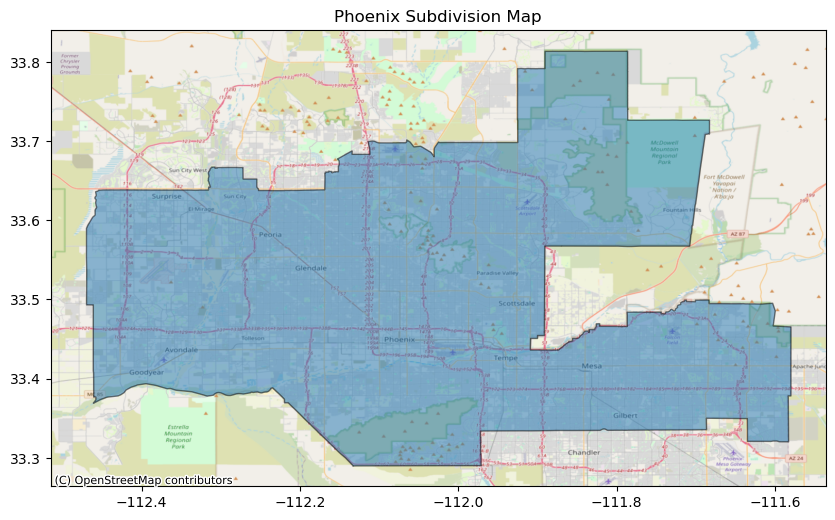

In [2]:
# Read in Arizona shapefile
arizona = gpd.read_file("data/tl_2022_04_cousub/tl_2022_04_cousub.shp")

# Select Phoenix subdivision
phoenix = arizona[arizona['NAME'] == 'Phoenix']

# Set axis for Phoenix
ax = phoenix.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# Add basemap from OpenStreetMap using Contextily
ctx.add_basemap(ax, crs=phoenix.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Add title
plt.title("Phoenix Subdivision Map")

# Display map
plt.show()

In [3]:
# Access catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Set temporal range of interest
time_range = "2017-01-01/2020-01-01"

# Set Phoenix bounding box
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# Search catalog
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = time_range)

# Get items from search
items = search.item_collection()
print(f'There are {len(items)} items in the search.')

There are 4 items in the search.


In [4]:
item_2020 = items[0]
item_2017 = items[3]

item_2017.properties['proj:epsg']

4326

In [5]:
# Convert CRS of Phoenix subdivision GeoDataFrame
phoenix = phoenix.to_crs('4326')

# Store raster data from items
bii_2020 = rioxr.open_rasterio(item_2020.assets['data'].href)
bii_2017 = rioxr.open_rasterio(item_2017.assets['data'].href)

# Remove length band dimension
bii_2020 = bii_2020.squeeze()
bii_2017 = bii_2017.squeeze()

# Remove coordinates associated to band
bii_2020 = bii_2020.drop('band')
bii_2017 = bii_2017.drop('band')

# Create bbox polygon
bbox_polygon = Polygon([(bbox[0], bbox[1]),
                        (bbox[2], bbox[1]),
                        (bbox[2], bbox[3]),
                        (bbox[0], bbox[3])])

# Create GeoDataFrame
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_polygon], crs='4326')

# Clip the rasters to the bounding box
bii_2017_clipped = bii_2017.rio.clip(phoenix.geometry, crs='4326')
bii_2020_clipped = bii_2020.rio.clip(phoenix.geometry, crs='4326')

# Calculate percent area with BII>=0.75
percent_area_2017 = (np.sum(bii_2017_clipped >= 0.75) / bii_2017_clipped.size) * 100
percent_area_2020 = (np.sum(bii_2020_clipped >= 0.75) / bii_2020_clipped.size) * 100

# Print percents
print(f"Percentage of area with BII>=0.75 in 2017: {percent_area_2017:.2f}%")
print(f"Percentage of area with BII>=0.75 in 2020: {percent_area_2020:.2f}%")

Percentage of area with BII>=0.75 in 2017: 4.18%
Percentage of area with BII>=0.75 in 2020: 3.81%


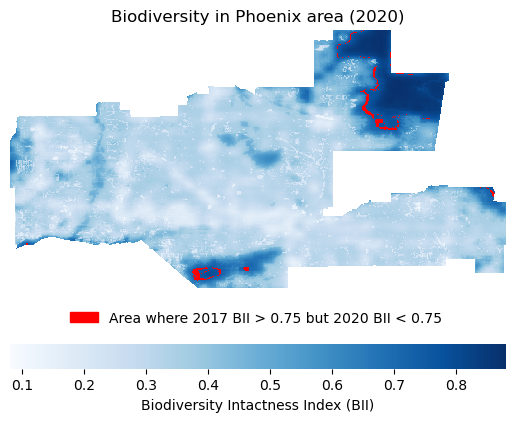

In [6]:
# Make raster representing the area with BII>=0.75 in 2017 that was lost by 2020
lost_area = (bii_2017_clipped > 0.75) & (bii_2020_clipped < 0.75)

# Convert bools to binary values
lost_area_numeric = lost_area.astype(int)

# Replace zeros with NaN
cropped_lost_area = lost_area_numeric.where(lost_area_numeric == 1)

# Define custom colormap for the lost area
custom_cmap = ListedColormap(['red'])

# Plot figure and axis with custom colorbar
fig, ax = plt.subplots()
im = bii_2020_clipped.plot(ax=ax, cmap='Blues', add_colorbar=False)
cropped_lost_area.plot(ax=ax, cmap=custom_cmap, add_colorbar=False)
cbar = plt.colorbar(im, orientation='horizontal', pad=0.15)
cbar.set_label('Biodiversity Intactness Index (BII)')
cbar.outline.set_visible(False)

# Remove frame around the entire figure
ax.set_frame_on(False)

# Create legend patch
red_patch = Patch(color='red', label='Area where 2017 BII > 0.75 but 2020 BII < 0.75')

# Add legend below the figure
legend_ax = fig.add_axes([0.80, 0.2, 0.02, 0.12])
legend_ax.legend(handles=[red_patch], ncol=1, frameon=False)
legend_ax.axis('off')

# Add title
title_text = 'Biodiversity in Phoenix area (2020)'
ax.set_title(title_text)

# Remove axis labels and ticks
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])

# Show the plot
plt.show()